### HDBSCAN → Mean-Shift → GMM

Pipeline 3 (HDBSCAN → Mean-Shift → GMM)
Best silhouette score: 0.7562929739565915
Best HDBSCAN params: {'min_samples': 9, 'min_cluster_size': 15}


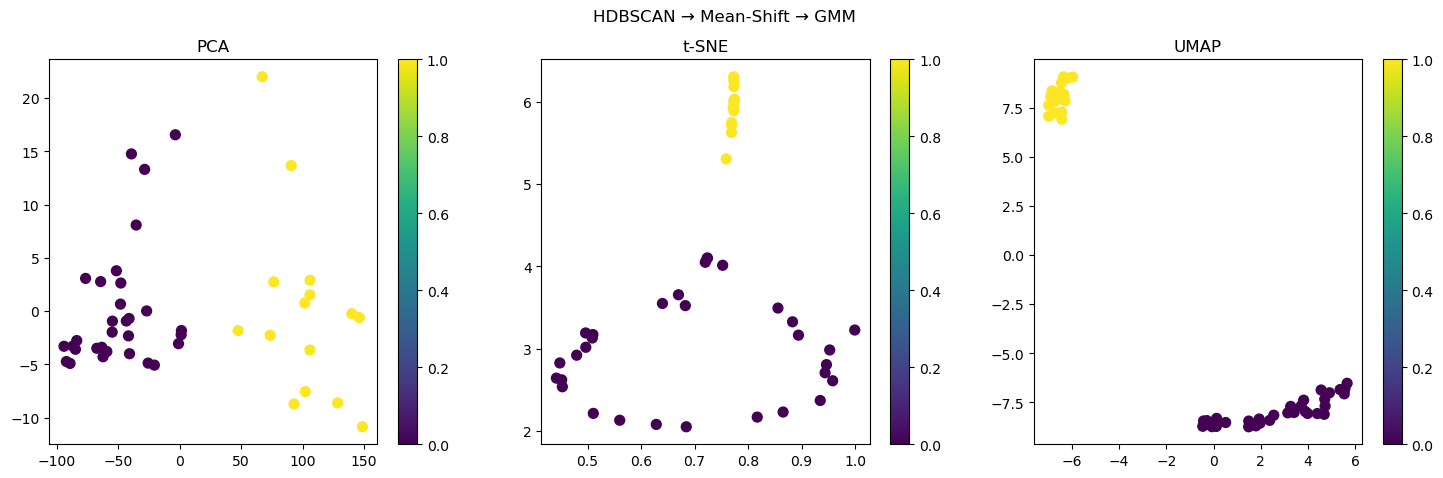

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


# Dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation and hyperparameter tuning
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

# Clustering algorithms
import hdbscan
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture

import random
random_state = 42
np.random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Update this path if needed
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# -------------------------------
# Visualization Function
# -------------------------------
def visualize_clusters(X, labels, title="Clusters"):
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    X_umap = reducer.fit_transform(X)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sc1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    axs[0].set_title("PCA")
    plt.colorbar(sc1, ax=axs[0])
    
    sc2 = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
    axs[1].set_title("t-SNE")
    plt.colorbar(sc2, ax=axs[1])
    
    sc3 = axs[2].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=50)
    axs[2].set_title("UMAP")
    plt.colorbar(sc3, ax=axs[2])
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Pipeline 3: HDBSCAN → Mean-Shift → GMM
# -------------------------------
def run_pipeline_hdbscan_meanshift_gmm(X, n_iter=20):
    best_score = -1
    best_params = None
    best_labels = None  # Tuple: (hdb_labels, ms_labels, gmm_labels, mask)
    
    param_grid = {
       'min_cluster_size': list(range(5, 50)),
       'min_samples': list(range(1, 20))
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        # Step 1: HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'],
                                    min_samples=params['min_samples'])
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Mean-Shift clustering (automatic detection)
        meanshift = MeanShift()
        ms_labels = meanshift.fit_predict(X_filtered)
        unique_labels = np.unique(ms_labels)
        n_components = len(unique_labels)
        # Calculate cluster centers from Mean-Shift result
        centers = []
        for label in unique_labels:
            centers.append(X_filtered[ms_labels == label].mean(axis=0))
        centers = np.array(centers)
        
        # Step 3: GMM using centers as initialization
        try:
            gmm = GaussianMixture(n_components=n_components, means_init=centers, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        try:
            score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            score = -1
        
        if score > best_score:
            best_score = score
            best_params = params
            best_labels = (hdb_labels, ms_labels, gmm_labels, mask)
    
    print("Pipeline 3 (HDBSCAN → Mean-Shift → GMM)")
    print("Best silhouette score:", best_score)
    print("Best HDBSCAN params:", best_params)
    return best_labels, best_score

if __name__ == "__main__":
    labels_pipe3, score3 = run_pipeline_hdbscan_meanshift_gmm(X)
    if labels_pipe3 is not None:
        hdb_labels, ms_labels, gmm_labels, mask = labels_pipe3
        visualize_clusters(X[mask], gmm_labels, title="HDBSCAN → Mean-Shift → GMM")


Pipeline 3 (HDBSCAN → MeanShift → GMM) with fixed clusters = 5
Best silhouette score: 0.5926428536074329
Best HDBSCAN params: {'min_samples': 4, 'min_cluster_size': 16}


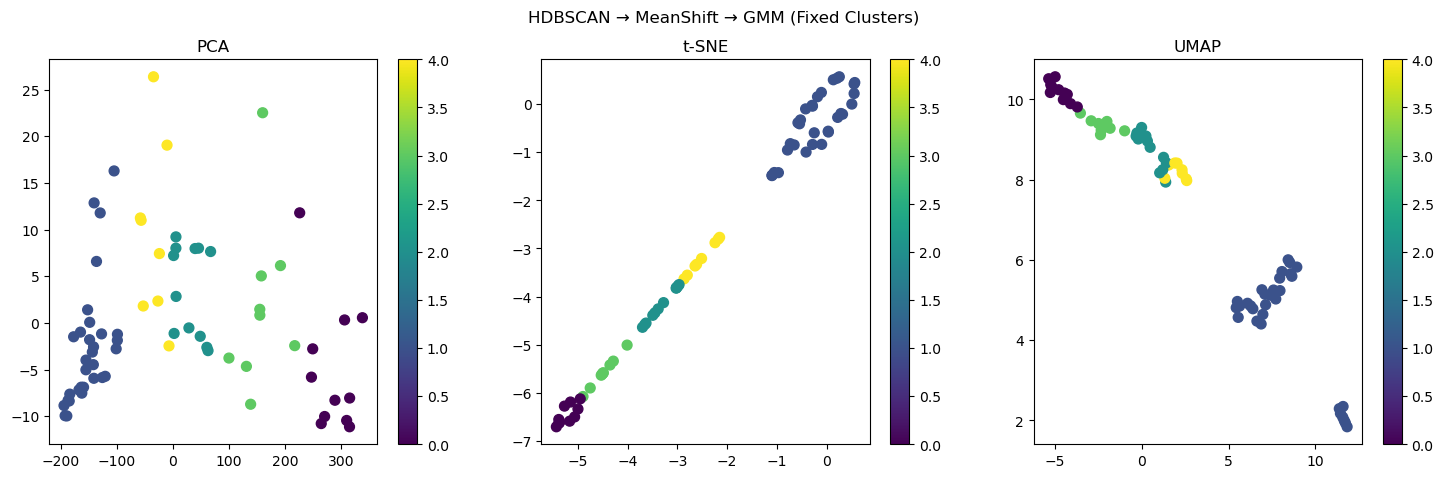

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation and hyperparameter tuning
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

# Clustering algorithms
import hdbscan
from sklearn.cluster import MeanShift, KMeans
from sklearn.mixture import GaussianMixture

import random
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Update this path to your CSV file
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# -------------------------------
# Visualization Function
# -------------------------------
def visualize_clusters(X, labels, title="Clusters"):
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    X_umap = reducer.fit_transform(X)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sc1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    axs[0].set_title("PCA")
    plt.colorbar(sc1, ax=axs[0])
    
    sc2 = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
    axs[1].set_title("t-SNE")
    plt.colorbar(sc2, ax=axs[1])
    
    sc3 = axs[2].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=50)
    axs[2].set_title("UMAP")
    plt.colorbar(sc3, ax=axs[2])
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Pipeline 3: HDBSCAN → MeanShift → GMM with Fixed Clusters (n=5)
# -------------------------------
def run_pipeline_hdbscan_meanshift_gmm_fixed(X, fixed_clusters=5, n_iter=20):
    best_score = -1
    best_params = None
    best_labels = None  # Tuple: (hdb_labels, ms_labels, gmm_labels, mask)
    
    # Define a parameter grid for HDBSCAN
    param_grid = {
       'min_cluster_size': list(range(5, 50)),
       'min_samples': list(range(1, 20))
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        # Step 1: HDBSCAN to filter noise
        clusterer = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'],
                                    min_samples=params['min_samples'])
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        
        # Step 2: Run MeanShift on filtered data (for consistency with pipeline naming)
        meanshift = MeanShift()
        ms_labels = meanshift.fit_predict(X_filtered)
        # (We ignore the number of clusters from MeanShift here.)
        
        # Instead, use KMeans to force exactly fixed_clusters (e.g., 5) and compute centers
        kmeans = KMeans(n_clusters=fixed_clusters, random_state=random_state)
        kmeans.fit(X_filtered)
        centers = kmeans.cluster_centers_
        
        # Step 3: GMM using fixed number of clusters and initial centers from KMeans
        try:
            gmm = GaussianMixture(n_components=fixed_clusters, means_init=centers, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Evaluate clustering using the silhouette score
        try:
            score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            score = -1
        
        if score > best_score:
            best_score = score
            best_params = params
            best_labels = (hdb_labels, ms_labels, gmm_labels, mask)
    
    print("Pipeline 3 (HDBSCAN → MeanShift → GMM) with fixed clusters =", fixed_clusters)
    print("Best silhouette score:", best_score)
    print("Best HDBSCAN params:", best_params)
    return best_labels, best_score

if __name__ == "__main__":
    fixed_clusters = 5  # Set the fixed number of clusters here
    labels_pipe3, score3 = run_pipeline_hdbscan_meanshift_gmm_fixed(X, fixed_clusters=fixed_clusters)
    if labels_pipe3 is not None:
        hdb_labels, ms_labels, gmm_labels, mask = labels_pipe3
        visualize_clusters(X[mask], gmm_labels, title="HDBSCAN → MeanShift → GMM (Fixed Clusters)")

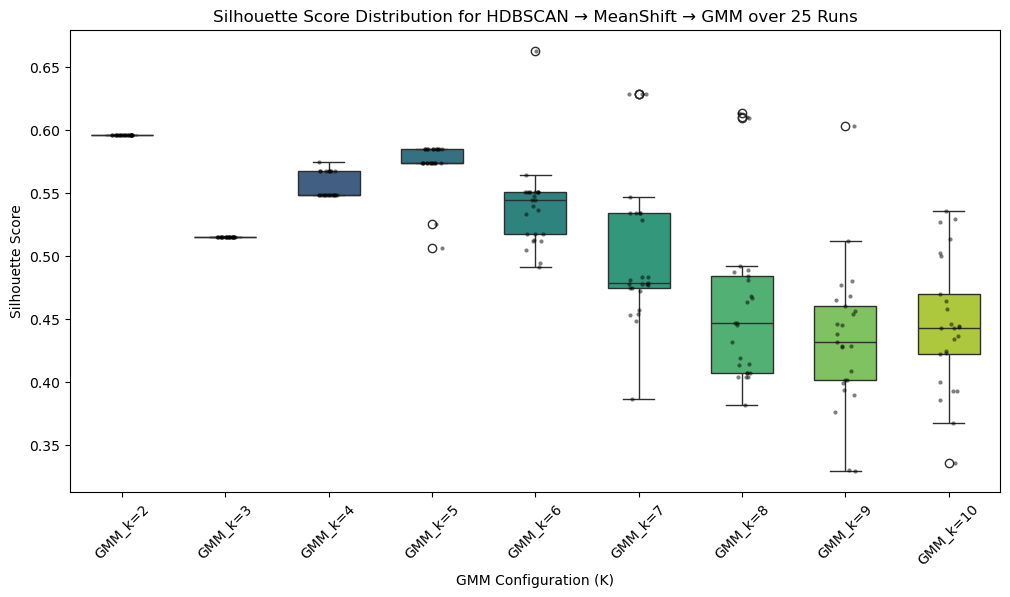

Friedman test statistic: 142.9867, p-value: 0.0000


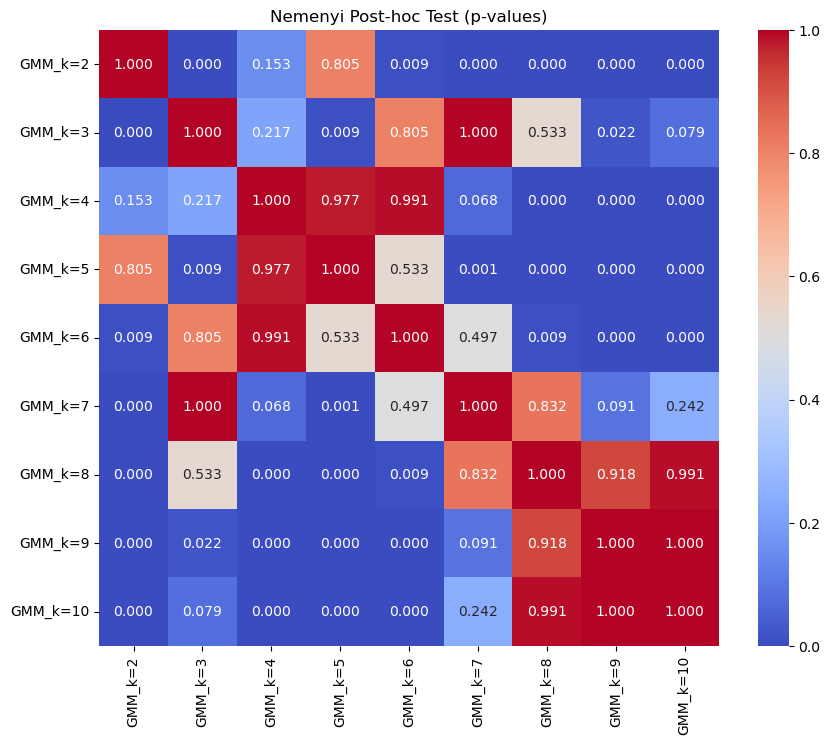

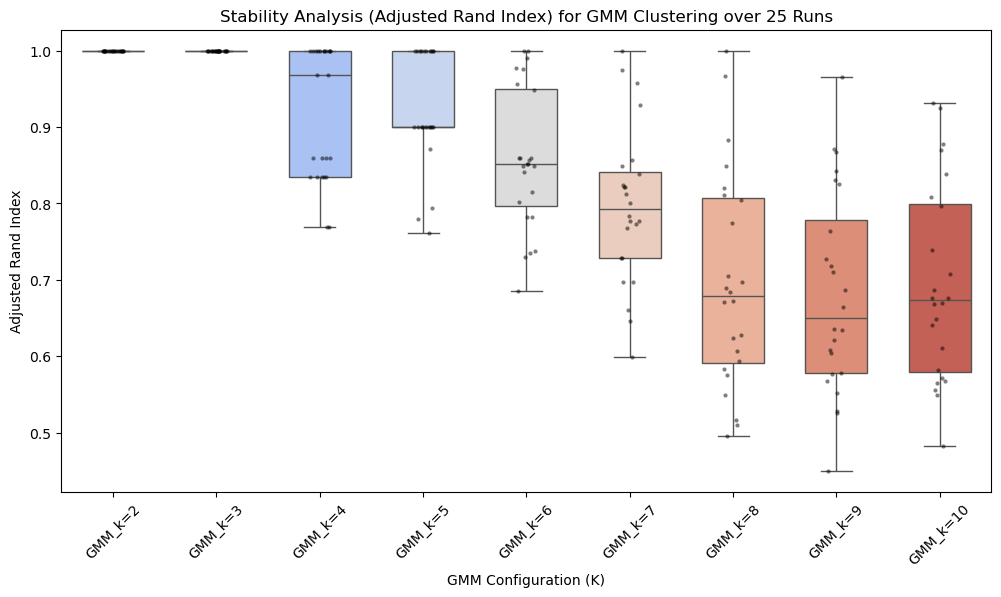

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
import hdbscan

warnings.filterwarnings("ignore")

# Load dataset
data = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")
data = data.drop('Cell Number', axis=1)
X = data.select_dtypes(include=[np.number]).values  # Use raw numerical values

# Define range of clusters
k_values = list(range(2, 11))  # 2 to 10 clusters
n_runs = 25  # Number of random runs

# Store silhouette scores and stability scores
silhouette_scores = {f'GMM_k={k}': [] for k in k_values}
stability_scores = {f'GMM_k={k}': [] for k in k_values}

previous_labels = {k: None for k in k_values}  # Store previous run labels for stability check

for run in range(n_runs):
    try:
        # Step 1: HDBSCAN to remove noise
        hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
        hdb_labels = hdbscan_clusterer.fit_predict(X)
        mask = hdb_labels != -1  # Keep only clustered points

        if np.sum(mask) < 2:
            print(f"Run {run}: Too many points classified as noise, skipping...")
            continue  # Skip iteration if very few points remain
        
        X_filtered = X[mask]  # Keep only clustered data (raw, unscaled)

        # Step 2: MeanShift clustering
        meanshift = MeanShift()
        ms_labels = meanshift.fit_predict(X_filtered)

        # Step 3: Fit GMM for different K values
        for k in k_values:
            try:
                gmm = GaussianMixture(n_components=k, covariance_type="diag", max_iter=500, random_state=run)
                gmm_labels = gmm.fit_predict(X_filtered)

                # Compute Silhouette Score only if multiple clusters exist
                if len(set(gmm_labels)) > 1:
                    score = silhouette_score(X_filtered, gmm_labels)
                    silhouette_scores[f'GMM_k={k}'].append(score)
                else:
                    silhouette_scores[f'GMM_k={k}'].append(np.nan)  # Avoid silhouette error for single clusters

                # Compute Stability Score (Adjusted Rand Index with previous run labels)
                if previous_labels[k] is not None:
                    stability = adjusted_rand_score(previous_labels[k], gmm_labels)
                    stability_scores[f'GMM_k={k}'].append(stability)
                previous_labels[k] = gmm_labels  # Update previous labels

            except Exception as e:
                print(f"Run {run}, K={k}: Error encountered - {e}")
                continue

    except Exception as e:
        print(f"Run {run}: Error encountered - {e}")
        continue

# Convert results to DataFrames
silhouette_df = pd.DataFrame(silhouette_scores)
stability_df = pd.DataFrame(stability_scores)

# Drop columns with all NaN values
silhouette_df.dropna(axis=1, how="all", inplace=True)
stability_df.dropna(axis=1, how="all", inplace=True)

# Ensure there is enough data for statistical analysis
if not silhouette_df.empty:
    # Plot Silhouette Score distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=silhouette_df, palette="viridis", width=0.6)
    sns.stripplot(data=silhouette_df, color="black", size=3, jitter=True, alpha=0.5)
    plt.title(f'Silhouette Score Distribution for HDBSCAN → MeanShift → GMM over {n_runs} Runs')
    plt.xlabel('GMM Configuration (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(rotation=45)
    plt.show()

    # Perform Friedman test if there are enough valid runs
    if silhouette_df.shape[0] > 2:
        stat, p_value = friedmanchisquare(*[silhouette_df[col] for col in silhouette_df.columns])
        print(f'Friedman test statistic: {stat:.4f}, p-value: {p_value:.4f}')

        if p_value < 0.05:
            # Perform Nemenyi post-hoc test
            nemenyi_results = posthoc_nemenyi_friedman(silhouette_df.values)
            
            # Visualize the Nemenyi test results
            plt.figure(figsize=(10, 8))
            sns.heatmap(nemenyi_results, annot=True, cmap="coolwarm", fmt=".3f", xticklabels=silhouette_df.columns, yticklabels=silhouette_df.columns)
            plt.title('Nemenyi Post-hoc Test (p-values)')
            plt.show()
        else:
            print('No significant differences found among the GMM cluster configurations.')
    else:
        print("Not enough valid data for the Friedman test.")
else:
    print("Not enough valid data for analysis.")

# Stability Analysis Plot
if not stability_df.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=stability_df, palette="coolwarm", width=0.6)
    sns.stripplot(data=stability_df, color="black", size=3, jitter=True, alpha=0.5)
    plt.title(f'Stability Analysis (Adjusted Rand Index) for GMM Clustering over {n_runs} Runs')
    plt.xlabel('GMM Configuration (K)')
    plt.ylabel('Adjusted Rand Index')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Not enough valid data for stability analysis.")


### with feature engineering 


Feature Weights:
Area: 1
Perimeter: 1
Major Axis Length: 1
Minor Axis Length: 1
Soma Diameter: 1
Aspect Ratio: 1
Circularity: 2.5
Solidity: 2.5
Local Homogeneity: 1


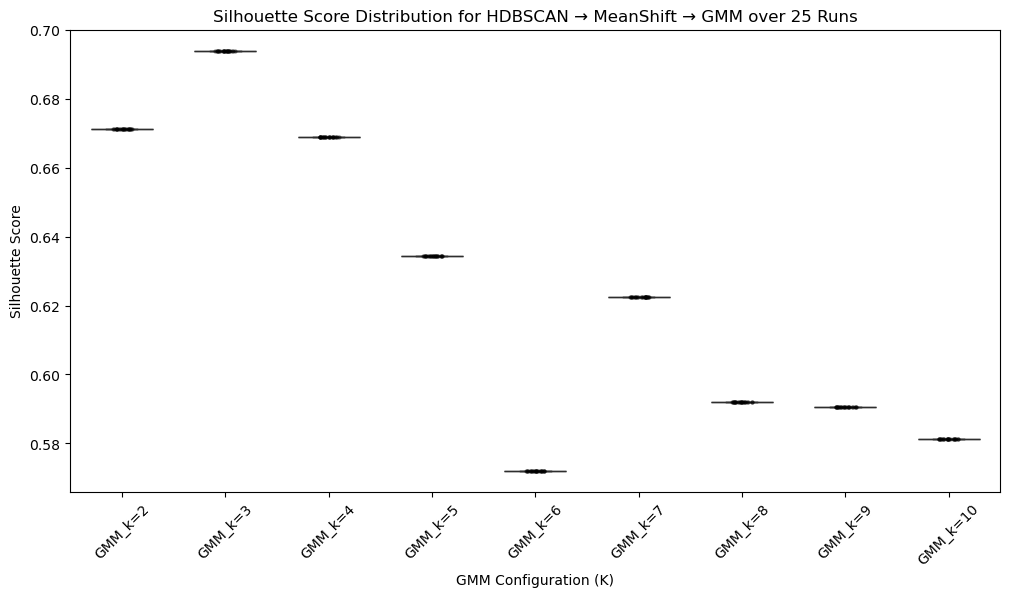

Friedman test statistic: 200.0000, p-value: 0.0000


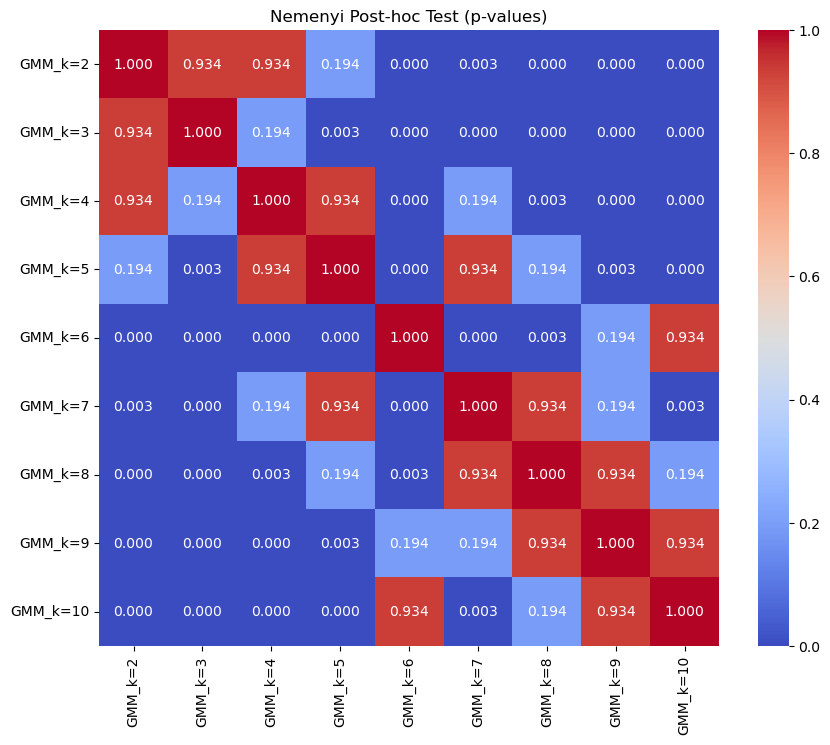

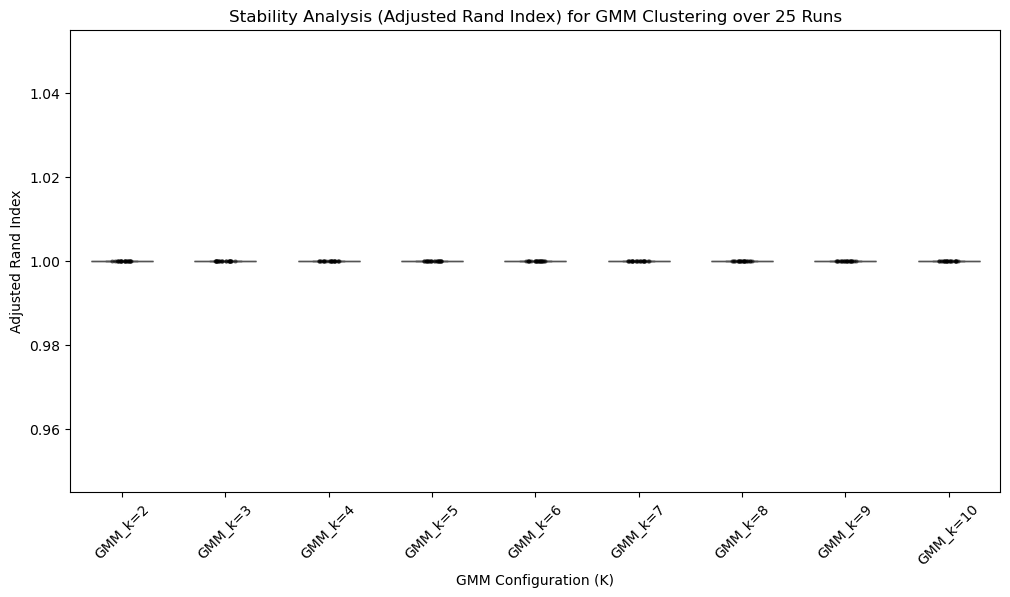

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import umap

from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
import hdbscan

warnings.filterwarnings("ignore")

# Load dataset
data = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")
data = data.drop('Cell Number', axis=1)

# Define feature weights
feature_weights = {
    'Solidity': 2.5,
    'Circularity': 2.5,
    'LocalHomogeneity': 2.5
}

# Apply feature weights
for feature, weight in feature_weights.items():
    if feature in data.columns:
        data[feature] *= weight

# Print all feature weights (default weight = 1 if not modified)
print("Feature Weights:")
for feature in data.columns:
    weight = feature_weights.get(feature, 1)  # Default weight is 1 if not in modified list
    print(f"{feature}: {weight}")

# UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_components=7, random_state=42)
X_umap = umap_reducer.fit_transform(data.select_dtypes(include=[np.number]).values)  # No scaling

# Define range of clusters
k_values = list(range(2, 11))  # 2 to 10 clusters
n_runs = 25  # Number of random runs

# Store silhouette scores and stability scores
silhouette_scores = {f'GMM_k={k}': [] for k in k_values}
stability_scores = {f'GMM_k={k}': [] for k in k_values}

previous_labels = {k: None for k in k_values}  # Store previous run labels for stability check

for run in range(n_runs):
    try:
        # Step 1: HDBSCAN to remove noise
        hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
        hdb_labels = hdbscan_clusterer.fit_predict(X_umap)
        mask = hdb_labels != -1  # Keep only clustered points

        if np.sum(mask) < 2:
            print(f"Run {run}: Too many points classified as noise, skipping...")
            continue  # Skip iteration if very few points remain
        
        X_filtered = X_umap[mask]  # Keep only clustered data

        # Step 2: MeanShift clustering
        meanshift = MeanShift()
        ms_labels = meanshift.fit_predict(X_filtered)

        # Step 3: Fit GMM for different K values
        for k in k_values:
            try:
                gmm = GaussianMixture(n_components=k, covariance_type="diag", max_iter=500, random_state=42)
                gmm_labels = gmm.fit_predict(X_filtered)

                # Compute Silhouette Score only if multiple clusters exist
                if len(set(gmm_labels)) > 1:
                    score = silhouette_score(X_filtered, gmm_labels)
                    silhouette_scores[f'GMM_k={k}'].append(score)
                else:
                    silhouette_scores[f'GMM_k={k}'].append(np.nan)  # Avoid silhouette error for single clusters

                # Compute Stability Score (Adjusted Rand Index with previous run labels)
                if previous_labels[k] is not None:
                    stability = adjusted_rand_score(previous_labels[k], gmm_labels)
                    stability_scores[f'GMM_k={k}'].append(stability)
                previous_labels[k] = gmm_labels  # Update previous labels

            except Exception as e:
                print(f"Run {run}, K={k}: Error encountered - {e}")
                continue

    except Exception as e:
        print(f"Run {run}: Error encountered - {e}")
        continue

# Convert results to DataFrames
silhouette_df = pd.DataFrame(silhouette_scores)
stability_df = pd.DataFrame(stability_scores)

# Drop columns with all NaN values
silhouette_df.dropna(axis=1, how="all", inplace=True)
stability_df.dropna(axis=1, how="all", inplace=True)

# Save CSV for n = 5 clusters
gmm_5 = GaussianMixture(n_components=5, covariance_type="diag", max_iter=500, random_state=42)
data['GMM_5_Labels'] = gmm_5.fit_predict(X_umap)
data.to_csv("clustered_data_n5000HDBSCAN_MEANSHIFT_GMM.csv", index=False)

# Plot Silhouette Score distribution
if not silhouette_df.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=silhouette_df, palette="viridis", width=0.6)
    sns.stripplot(data=silhouette_df, color="black", size=3, jitter=True, alpha=0.5)
    plt.title(f'Silhouette Score Distribution for HDBSCAN → MeanShift → GMM over {n_runs} Runs')
    plt.xlabel('GMM Configuration (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(rotation=45)
    plt.show()

    # Perform Friedman test if there are enough valid runs
    if silhouette_df.shape[0] > 2:
        stat, p_value = friedmanchisquare(*[silhouette_df[col] for col in silhouette_df.columns])
        print(f'Friedman test statistic: {stat:.4f}, p-value: {p_value:.4f}')

        if p_value < 0.05:
            # Perform Nemenyi post-hoc test
            nemenyi_results = posthoc_nemenyi_friedman(silhouette_df.values)
            
            # Visualize the Nemenyi test results
            plt.figure(figsize=(10, 8))
            sns.heatmap(nemenyi_results, annot=True, cmap="coolwarm", fmt=".3f", xticklabels=silhouette_df.columns, yticklabels=silhouette_df.columns)
            plt.title('Nemenyi Post-hoc Test (p-values)')
            plt.show()
        else:
            print('No significant differences found among the GMM cluster configurations.')
    else:
        print("Not enough valid data for the Friedman test.")
else:
    print("Not enough valid data for analysis.")

# Stability Analysis Plot
if not stability_df.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=stability_df, palette="coolwarm", width=0.6)
    sns.stripplot(data=stability_df, color="black", size=3, jitter=True, alpha=0.5)
    plt.title(f'Stability Analysis (Adjusted Rand Index) for GMM Clustering over {n_runs} Runs')
    plt.xlabel('GMM Configuration (K)')
    plt.ylabel('Adjusted Rand Index')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Not enough valid data for stability analysis.")


### HDBSCAN-MEANSHIFT-GMM

Stability Scores for DPGMM_k=2:
  Cluster 0: 0.9706
  Cluster 1: 0.9800
Stability Scores for DPGMM_k=3:
  Cluster 0: 0.9412
  Cluster 1: 0.9706
  Cluster 2: 0.9697
Stability Scores for DPGMM_k=4:
  Cluster 0: 0.9231
  Cluster 1: 0.9583
  Cluster 2: 0.9500
  Cluster 3: 0.9630
Stability Scores for DPGMM_k=5:
  Cluster 0: 0.9375
  Cluster 1: 0.9375
  Cluster 2: 0.9231
  Cluster 3: 0.9630
  Cluster 4: 0.9167
Stability Scores for DPGMM_k=6:
  Cluster 0: 0.9375
  Cluster 1: 0.9375
  Cluster 3: 0.9630
  Cluster 4: 0.9167
  Cluster 5: 0.9231
Stability Scores for DPGMM_k=7:
  Cluster 0: 0.8889
  Cluster 1: 0.9375
  Cluster 3: 0.9630
  Cluster 4: 0.9167
  Cluster 5: 0.9231
  Cluster 6: 0.8571
Stability Scores for DPGMM_k=8:
  Cluster 0: 0.8750
  Cluster 1: 0.9286
  Cluster 3: 0.9630
  Cluster 4: 0.9231
  Cluster 5: 0.8333
  Cluster 6: 0.8333
  Cluster 7: 0.9000
Stability Scores for DPGMM_k=9:
  Cluster 0: 0.8750
  Cluster 1: 0.8333
  Cluster 3: 0.9615
  Cluster 4: 0.9231
  Cluster 5: 0.8333
  Cl

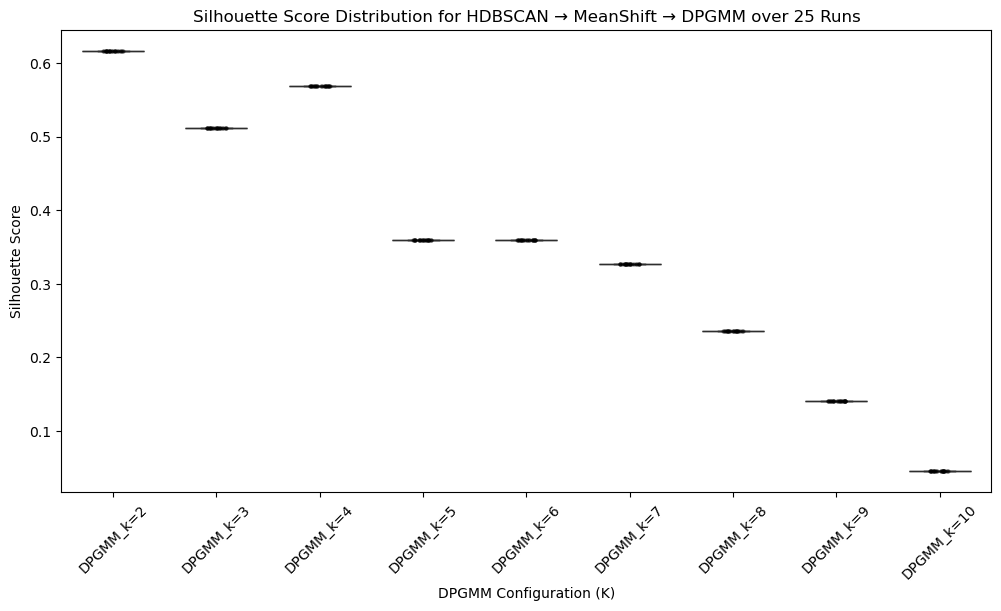

Friedman test statistic: 200.0000, p-value: 0.0000


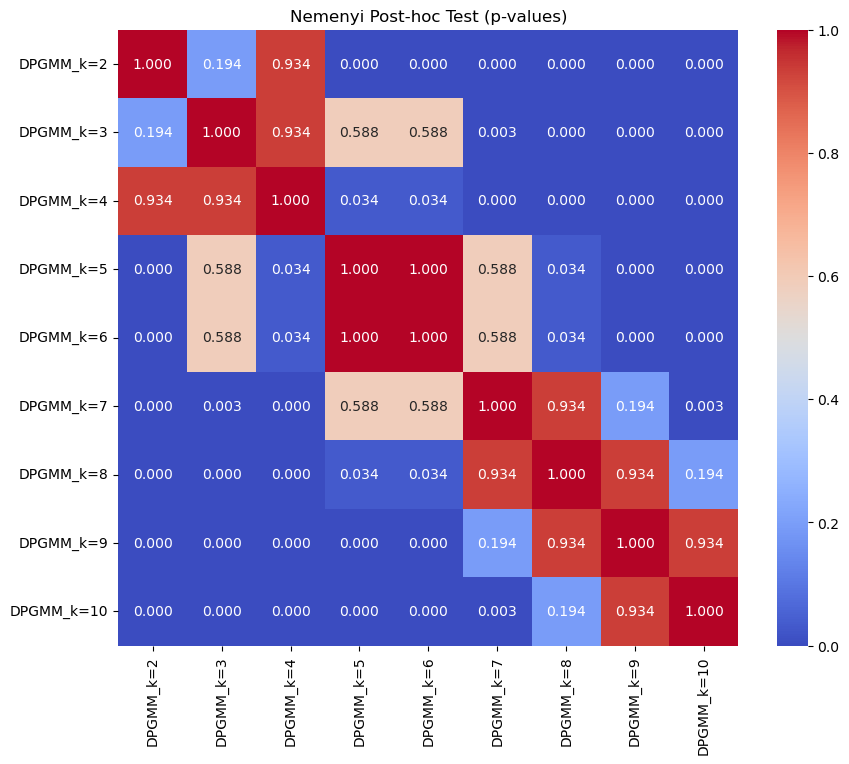

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.cluster import MeanShift
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
import hdbscan
from scipy.spatial.distance import pdist, squareform

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
data = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")
data = data.drop('Cell Number', axis=1)
X = data.select_dtypes(include=[np.number]).values  # Use raw numerical values (No Scaling)

# Define range of clusters
k_values = list(range(2, 11))  # 2 to 10 clusters
n_runs = 25  # Number of random runs

# Store silhouette scores and cluster assignments
silhouette_scores = {f'DPGMM_k={k}': [] for k in k_values}
cluster_assignments = {k: [] for k in k_values}  # Store labels across runs

for run in range(n_runs):
    try:
        # Step 1: HDBSCAN to remove noise
        hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
        hdb_labels = hdbscan_clusterer.fit_predict(X)
        mask = hdb_labels != -1  # Keep only clustered points

        if np.sum(mask) < 2:
            print(f"Run {run}: Too many points classified as noise, skipping...")
            continue  # Skip iteration if very few points remain
        
        X_filtered = X[mask]  # Keep only clustered data (Raw, No Scaling)

        # Step 2: MeanShift clustering
        meanshift = MeanShift()
        ms_labels = meanshift.fit_predict(X_filtered)

        # Step 3: Fit DPGMM for different K values
        for k in k_values:
            try:
                dpgmm = BayesianGaussianMixture(
                    n_components=k, covariance_type="diag", max_iter=500, 
                    weight_concentration_prior_type='dirichlet_process', random_state=42  # Fixed seed
                )
                dpgmm_labels = dpgmm.fit_predict(X_filtered)

                # Store cluster assignments for stability calculation
                cluster_assignments[k].append(dpgmm_labels)

                # Compute Silhouette Score only if multiple clusters exist
                if len(set(dpgmm_labels)) > 1:
                    score = silhouette_score(X_filtered, dpgmm_labels)
                    silhouette_scores[f'DPGMM_k={k}'].append(score)
                else:
                    silhouette_scores[f'DPGMM_k={k}'].append(np.nan)  # Avoid silhouette error for single clusters
            except Exception as e:
                print(f"Run {run}, K={k}: Error encountered - {e}")
                continue

    except Exception as e:
        print(f"Run {run}: Error encountered - {e}")
        continue

# Convert results to DataFrame
silhouette_df = pd.DataFrame(silhouette_scores)

# Drop columns with all NaN values
silhouette_df.dropna(axis=1, how="all", inplace=True)

# --- Stability Score Calculation ---
def compute_stability(assignments):
    """
    Computes stability scores for each cluster based on Jaccard similarity.
    """
    if len(assignments) < 2:
        return None  # Not enough runs for stability computation

    num_points = len(assignments[0])  # Number of data points

    # Compute co-occurrence matrix (how often points are clustered together)
    co_matrix = np.zeros((num_points, num_points))

    for run_assignments in assignments:
        for i in range(num_points):
            for j in range(num_points):
                if run_assignments[i] == run_assignments[j]:  
                    co_matrix[i, j] += 1  

    # Normalize by number of runs to get probability of co-clustering
    co_matrix /= len(assignments)

    # Compute Jaccard similarity scores
    stability_scores = 1 - pdist(co_matrix, metric='jaccard')  # Pairwise Jaccard distances
    stability_matrix = squareform(stability_scores)  # Convert to square matrix form

    # Get per-cluster stability by averaging Jaccard scores within each cluster
    cluster_stabilities = {}
    for run_assignments in assignments:
        unique_clusters = np.unique(run_assignments)
        for cluster in unique_clusters:
            indices = np.where(run_assignments == cluster)[0]  # Indices of points in cluster
            if len(indices) > 1:
                stability = np.mean(stability_matrix[np.ix_(indices, indices)])  # Mean Jaccard score within cluster
                cluster_stabilities[cluster] = stability

    return cluster_stabilities

# Compute stability for each K value
stability_results = {k: compute_stability(cluster_assignments[k]) for k in k_values}

# Print stability results
for k, stability in stability_results.items():
    if stability:
        print(f"Stability Scores for DPGMM_k={k}:")
        for cluster_id, stability_score in stability.items():
            print(f"  Cluster {cluster_id}: {stability_score:.4f}")

# --- Visualization ---
if not silhouette_df.empty:
    # Plot Silhouette Score distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=silhouette_df, palette="viridis", width=0.6)
    sns.stripplot(data=silhouette_df, color="black", size=3, jitter=True, alpha=0.5)
    plt.title(f'Silhouette Score Distribution for HDBSCAN → MeanShift → DPGMM over {n_runs} Runs')
    plt.xlabel('DPGMM Configuration (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(rotation=45)
    plt.show()

    # Perform Friedman test if there are enough valid runs
    if silhouette_df.shape[0] > 2:
        stat, p_value = friedmanchisquare(*[silhouette_df[col] for col in silhouette_df.columns])
        print(f'Friedman test statistic: {stat:.4f}, p-value: {p_value:.4f}')

        if p_value < 0.05:
            # Perform Nemenyi post-hoc test
            nemenyi_results = posthoc_nemenyi_friedman(silhouette_df.values)
            
            # Visualize the Nemenyi test results
            plt.figure(figsize=(10, 8))
            sns.heatmap(nemenyi_results, annot=True, cmap="coolwarm", fmt=".3f", xticklabels=silhouette_df.columns, yticklabels=silhouette_df.columns)
            plt.title('Nemenyi Post-hoc Test (p-values)')
            plt.show()
        else:
            print('No significant differences found among the DPGMM cluster configurations.')
    else:
        print("Not enough valid data for the Friedman test.")
else:
    print("Not enough valid data for analysis.")







In [20]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
import hdbscan
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score

# Set fixed random seed
random.seed(42)
np.random.seed(42)

# Load cell feature data
csv_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_path)

# Drop non-numeric columns (if any)
df = df.select_dtypes(include=[np.number])  # Keep only numeric features

X = df.values  # Use raw (unscaled) feature values

# HDBSCAN Clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
hdb_labels = hdb.fit_predict(X)

# MeanShift Clustering
ms = MeanShift()
ms_labels = ms.fit_predict(X)

# GMM Clustering (Fixed n = 5)
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(X)

df["Cluster"] = gmm_labels

# Save CSV file with Cluster Labels
output_csv_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_clustered_n5.csv"
df.to_csv(output_csv_path, index=False)
print(f"✅ CSV File Saved: {output_csv_path}")

# Compute Final Silhouette Score
sil_gmm = silhouette_score(X, gmm_labels)
print(f"\n🚀 **Final Silhouette Score (GMM, n=5): {sil_gmm:.4f}**")


✅ CSV File Saved: C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_clustered_n5.csv

🚀 **Final Silhouette Score (GMM, n=5): 0.5792**


✅ Saved clustered image with 5 clusters to C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\clustered_nissl_image_hdbscan-meanshift-gmm.png


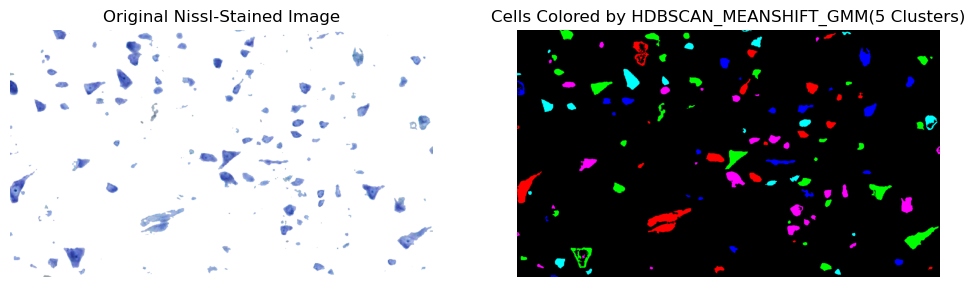

In [44]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load cluster data from CSV
csv_path = "clustered_data_n5000HDBSCAN_MEANSHIFT_GMM.csv"  # Removed the comma
df = pd.read_csv(csv_path)

# Ensure 'GMM_5_Labels' column exists
if 'GMM_5_Labels' not in df.columns:  # Fixed the typo
    raise KeyError("CSV must have a 'GMM_5_Labels' column!")

# Load and preprocess the Nissl-stained image
image = cv2.imread("restored_white_background_debug-Copy1.png")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
binary_image = cv2.adaptiveThreshold(
    gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Find contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours (noise)
filtered_contours = [c for c in contours if cv2.contourArea(c) > 42]  

num_detected_cells = len(filtered_contours)

# Validate cell count
if num_detected_cells != len(df):
    raise ValueError(f"Mismatch: Detected {num_detected_cells} cells, but CSV has {len(df)} rows.")

# Read cluster labels from CSV
clusters = df['GMM_5_Labels'].values  # Fixed column reference

# Define unique colors for 5 clusters
cluster_colors = {
    0: (255, 0, 0),   # Red
    1: (0, 255, 0),   # Green
    2: (0, 0, 255),   # Blue
    3: (255, 255, 0), # Yellow
    4: (255, 0, 255), # Magenta
}

# Create an empty color image
clustered_image = np.zeros_like(image)

# Draw each detected cell with its corresponding cluster color
for i, contour in enumerate(filtered_contours):
    cluster_id = clusters[i]  
    color = cluster_colors.get(cluster_id, (255, 255, 255))  # Default to white if cluster not found
    cv2.drawContours(clustered_image, [contour], -1, color, thickness=cv2.FILLED)

# Save the final clustered image
output_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\clustered_nissl_image_hdbscan-meanshift-gmm.png"
cv2.imwrite(output_path, clustered_image)
print(f"✅ Saved clustered image with 5 clusters to {output_path}")

# Show original and clustered images
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Nissl-Stained Image")
ax[0].axis("off")

ax[1].imshow(cv2.cvtColor(clustered_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Cells Colored by HDBSCAN_MEANSHIFT_GMM(5 Clusters)")
ax[1].axis("off")

plt.show()


In [46]:
import cv2
import numpy as np
import os

# Define cluster colors in BGR format (for 5 clusters)
cluster_colors = {
    0: (255, 0, 0),   # Red
    1: (0, 255, 0),   # Green
    2: (0, 0, 255),   # Blue
    3: (255, 255, 0), # Yellow
    4: (255, 0, 255)  # Magenta
}

def extract_cluster_masks(image, cluster_colors, output_folder):
    """
    Extracts and saves masks for each cluster using HSV-based color matching.

    :param image: Input Nissl-stained image with color-coded clusters.
    :param cluster_colors: Dictionary mapping cluster labels to BGR colors.
    :param output_folder: Directory to save segmented cluster images.
    """
    os.makedirs(output_folder, exist_ok=True)

    if image is None:
        raise FileNotFoundError("❌ Error: Unable to load image! Check the file path.")

    print(f"✅ Image successfully loaded with shape: {image.shape}")

    # Convert image to HSV for more robust color segmentation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for cluster_id, (b, g, r) in cluster_colors.items():
        # Convert BGR to HSV
        cluster_color_hsv = cv2.cvtColor(np.uint8([[[b, g, r]]]), cv2.COLOR_BGR2HSV)[0][0]

        # Define dynamic HSV bounds
        lower_bound = np.array([max(cluster_color_hsv[0] - 10, 0), 50, 50], dtype=np.uint8)
        upper_bound = np.array([min(cluster_color_hsv[0] + 10, 179), 255, 255], dtype=np.uint8)

        print(f"🔹 Processing Cluster {cluster_id}: HSV={cluster_color_hsv}, Lower={lower_bound}, Upper={upper_bound}")

        # Create a mask for the cluster
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

        if np.count_nonzero(mask) == 0:
            print(f"⚠️ Warning: No pixels found for cluster {cluster_id}!")
            continue

        # Extract the segmented cluster
        cluster_cells = cv2.bitwise_and(image, image, mask=mask)

        # Save extracted cluster image
        output_path = os.path.join(output_folder, f"cluster_{cluster_id}.png")
        cv2.imwrite(output_path, cluster_cells)
        print(f"✅ Saved segmented cluster {cluster_id} to {output_path}")

# Load the segmented image from your HDBSCAN-MeanShift-GMM model
image_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\clustered_nissl_image_hdbscan-meanshift-gmm.png"
image = cv2.imread(image_path)

# Define output folder for extracted clusters
output_folder = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm"

# Extract and save clusters
extract_cluster_masks(image, cluster_colors, output_folder)


✅ Image successfully loaded with shape: (854, 1460, 3)
🔹 Processing Cluster 0: HSV=[120 255 255], Lower=[110  50  50], Upper=[130 255 255]
✅ Saved segmented cluster 0 to C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm\cluster_0.png
🔹 Processing Cluster 1: HSV=[ 60 255 255], Lower=[50 50 50], Upper=[ 70 255 255]
✅ Saved segmented cluster 1 to C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm\cluster_1.png
🔹 Processing Cluster 2: HSV=[  0 255 255], Lower=[ 0 50 50], Upper=[ 10 255 255]
✅ Saved segmented cluster 2 to C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm\cluster_2.png
🔹 Processing Cluster 3: HSV=[ 90 255 255], Lower=[80 50 50], Upper=[100 255 255]
✅ Saved segmented cluster 3 to C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm\cluster_3.png
🔹 Processing Cluster 4: HSV=[150 255 255], Lower=[140  50  50], Upper=

In [48]:
import cv2
import numpy as np
import os

# Define cluster colors in BGR format (Yellow removed)
cluster_colors = {
    "red": (0, 0, 255),
    "green": (0, 255, 0),
    "blue": (255, 0, 0),
    "magenta": (255, 0, 255),
    "cyan": (255, 255, 0),
}

def extract_cluster_masks(image, cluster_colors, output_base_folder, tolerance=30, min_area=50):
    """
    Extracts and saves individual cluster cell images.

    :param image: Input clustered image.
    :param cluster_colors: Dictionary of cluster colors in BGR format.
    :param output_base_folder: Folder to store extracted clusters.
    :param tolerance: Color tolerance for better detection.
    :param min_area: Minimum contour area to filter small noise.
    """
    os.makedirs(output_base_folder, exist_ok=True)

    if image is None:
        print("❌ Error: Image not loaded! Check the file path.")
        return

    print(f"✅ Image loaded successfully: {image.shape}")

    for color_name, (b, g, r) in cluster_colors.items():
        # Create a folder for each cluster color
        folder = os.path.join(output_base_folder, color_name)
        os.makedirs(folder, exist_ok=True)

        # Define flexible color range
        lower_bound = np.array([max(b - tolerance, 0), max(g - tolerance, 0), max(r - tolerance, 0)], dtype=np.uint8)
        upper_bound = np.array([min(b + tolerance, 255), min(g + tolerance, 255), min(r + tolerance, 255)], dtype=np.uint8)

        print(f"🔍 Processing {color_name} cells...")

        # Create a mask for the specific cluster color
        mask = cv2.inRange(image, lower_bound, upper_bound)

        if np.count_nonzero(mask) == 0:
            print(f"⚠️ Warning: No cells found for {color_name}!")
            continue

        # Find cell contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        cell_count = 0
        for idx, cnt in enumerate(contours):
            if cv2.contourArea(cnt) < min_area:  # Ignore small regions
                continue

            x, y, w, h = cv2.boundingRect(cnt)
            cell_crop = image[y:y+h, x:x+w]

            # Save extracted cell image
            filename = os.path.join(folder, f"{color_name}_cell_{cell_count:03d}.png")
            cv2.imwrite(filename, cell_crop)
            cell_count += 1

        print(f"✅ Extracted {cell_count} {color_name} cells into {folder}")

# Load Image
image_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\clustered_nissl_image_hdbscan-meanshift-gmm.png"
image = cv2.imread(image_path)

# Define output folder
output_base_folder = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell"

# Run extraction with improved tolerance
extract_cluster_masks(image, cluster_colors, output_base_folder, tolerance=30)


✅ Image loaded successfully: (854, 1460, 3)
🔍 Processing red cells...
✅ Extracted 18 red cells into C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell\red
🔍 Processing green cells...
✅ Extracted 30 green cells into C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell\green
🔍 Processing blue cells...
✅ Extracted 21 blue cells into C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell\blue
🔍 Processing magenta cells...
✅ Extracted 27 magenta cells into C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell\magenta
🔍 Processing cyan cells...
✅ Extracted 20 cyan cells into C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell\cyan


In [50]:
import os
import cv2
import numpy as np

# Base directory containing clustered cell images (HDBSCAN + MeanShift + GMM unified output)
output_base = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell"

# Folder names corresponding to cluster colors (used in the unified output)
cluster_names = ["red", "green", "blue", "magenta", "cyan"]

# Output folder for summary images
summary_output_folder = os.path.join(output_base, "Cluster Summaries")
os.makedirs(summary_output_folder, exist_ok=True)

def compute_cluster_summaries(folder_path, cluster_name):
    """Compute the average, median, and most centered image for a given cluster folder."""
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]
    
    if not image_files:
        print(f"⚠️ No images found in {folder_path}. Skipping...")
        return

    images = []
    for f in image_files:
        img_path = os.path.join(folder_path, f)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"❌ Error reading image: {img_path}. Skipping...")
            continue

        images.append(img)

    if len(images) == 0:
        print(f"⚠️ No valid images in {folder_path}. Skipping...")
        return

    # Resize all images to the smallest found dimension
    min_shape = min((img.shape[:2] for img in images), key=lambda x: x[0] * x[1])
    images_resized = [cv2.resize(img, (min_shape[1], min_shape[0])) for img in images]

    # Compute the average image
    avg_image = np.mean(images_resized, axis=0).astype(np.uint8)

    # Compute the median image (pixel-wise)
    median_image = np.median(np.array(images_resized), axis=0).astype(np.uint8)

    # Find the most centered image (closest to mean)
    avg_vector = avg_image.flatten()
    distances = [np.linalg.norm(img.flatten() - avg_vector) for img in images_resized]
    center_image = images_resized[np.argmin(distances)]

    # Save results
    save_avg = os.path.join(summary_output_folder, f"average_{cluster_name}.png")
    save_median = os.path.join(summary_output_folder, f"median_{cluster_name}.png")
    save_center = os.path.join(summary_output_folder, f"center_{cluster_name}.png")

    cv2.imwrite(save_avg, avg_image)
    cv2.imwrite(save_median, median_image)
    cv2.imwrite(save_center, center_image)

    print(f"✅ Saved summary images for {cluster_name}: [Average, Median, Center]")

# Process each cluster from the unified model output
for cluster_name in cluster_names:
    cluster_folder = os.path.join(output_base, cluster_name)
    if os.path.exists(cluster_folder):
        compute_cluster_summaries(cluster_folder, cluster_name)
    else:
        print(f"⚠️ Folder {cluster_folder} not found!")

print("🎉 Unified Cluster Summary Generation Completed!")


✅ Saved summary images for red: [Average, Median, Center]
✅ Saved summary images for green: [Average, Median, Center]
✅ Saved summary images for blue: [Average, Median, Center]
✅ Saved summary images for magenta: [Average, Median, Center]
✅ Saved summary images for cyan: [Average, Median, Center]
🎉 Unified Cluster Summary Generation Completed!


In [73]:
import os
import cv2
import numpy as np
import pandas as pd

# Base directory containing clustered cell images
output_base = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell"

# Output folder for final processed images
final_output_folder = os.path.join(output_base, "final_cluster_outputs")
os.makedirs(final_output_folder, exist_ok=True)

# Load CSV containing cell features
csv_path = "clustered_data_n5000HDBSCAN_MEANSHIFT_GMM.csv"
df = pd.read_csv(csv_path)

# Ensure required columns exist
required_columns = {'Area', 'Perimeter', 'Major Axis Length', 'Minor Axis Length', 'Soma Diameter', 
                    'Aspect Ratio', 'Circularity', 'Solidity', 'Local Homogeneity', 'GMM_5_Labels'}
if not required_columns.issubset(df.columns):
    raise KeyError("CSV must contain all required feature columns, including 'GMM_5_Labels'!")

# Get valid cluster folders (excluding irrelevant ones)
valid_folders = [folder for folder in os.listdir(output_base) if os.path.isdir(os.path.join(output_base, folder))]
valid_folders = [folder for folder in valid_folders if folder not in ["final_cluster_outputs"]]
print(f"✅ Available cluster folders: {valid_folders}")

# Check if cluster count matches folders
if len(valid_folders) != df['GMM_5_Labels'].nunique():
    print("⚠️ WARNING: Number of cluster folders does not match unique GMM_5_Labels values in CSV!")

# Map numeric labels to folder names directly
cluster_mapping = {
    0: 'blue', 
    1: 'cyan', 
    2: 'magenta', 
    3: 'red', 
    4: 'green'
}
print(f"🗂️ Mapped Clusters: {cluster_mapping}")

# Function to compute average image
def compute_average_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]
    if not image_files:
        return None
    images = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_UNCHANGED) for f in image_files]
    min_shape = min((img.shape[:2] for img in images), key=lambda x: x[0] * x[1])
    images_resized = [cv2.resize(img, (min_shape[1], min_shape[0])) for img in images]
    return np.mean(images_resized, axis=0).astype(np.uint8)

# Function to find closest matching image by feature
def get_closest_image(cluster_folder, cluster_df, reference_value, feature_name):
    image_files = sorted([f for f in os.listdir(cluster_folder) if f.endswith(".png")])
    if not image_files:
        return None
    cluster_df['Feature_Diff'] = abs(cluster_df[feature_name] - reference_value)
    closest_idx = cluster_df.sort_values('Feature_Diff').index[0]
    closest_image_path = os.path.join(cluster_folder, image_files[closest_idx % len(image_files)])
    return cv2.imread(closest_image_path, cv2.IMREAD_UNCHANGED)

# Process each cluster
for cluster_id, cluster_name in cluster_mapping.items():
    if cluster_name in valid_folders:
        cluster_folder = os.path.join(output_base, cluster_name)
        cluster_df = df[df['GMM_5_Labels'] == cluster_id]

        if not cluster_df.empty:
            avg_image = compute_average_image(cluster_folder)
            center_image = get_closest_image(cluster_folder, cluster_df, cluster_df['Area'].mean(), 'Area')
            median_image = get_closest_image(cluster_folder, cluster_df, cluster_df['Area'].median(), 'Area')

            # Ensure all images have the same shape before blending
            images = [img for img in [avg_image, center_image, median_image] if img is not None]
            if len(images) == 3:
                min_shape = min([img.shape[:2] for img in images], key=lambda x: x[0] * x[1])
                avg_image_resized = cv2.resize(avg_image, (min_shape[1], min_shape[0]))
                center_image_resized = cv2.resize(center_image, (min_shape[1], min_shape[0]))
                median_image_resized = cv2.resize(median_image, (min_shape[1], min_shape[0]))

                # Compute final image
                final_image = (0.4 * avg_image_resized + 0.3 * median_image_resized + 0.3 * center_image_resized).astype(np.uint8)
                cv2.imwrite(os.path.join(final_output_folder, f"final_{cluster_name}.png"), final_image)
                print(f"✅ Processed final image for cluster '{cluster_name}'")
            else:
                print(f"⚠️ Skipping cluster '{cluster_name}' due to missing images!")
        else:
            print(f"⚠️ No data found in CSV for cluster '{cluster_name}'!")
    else:
        print(f"⚠️ Folder for cluster '{cluster_name}' not found!")

print("🎉 Pipeline Execution Completed!")


✅ Available cluster folders: ['blue', 'Cluster Summaries', 'cyan', 'final_processed_images', 'green', 'magenta', 'processed_data', 'red']
⚠️ WARNING: Number of cluster folders does not match unique GMM_5_Labels values in CSV!
🗂️ Mapped Clusters: {0: 'blue', 1: 'cyan', 2: 'magenta', 3: 'red', 4: 'green'}
✅ Processed final image for cluster 'blue'
✅ Processed final image for cluster 'cyan'
✅ Processed final image for cluster 'magenta'
✅ Processed final image for cluster 'red'
✅ Processed final image for cluster 'green'
🎉 Pipeline Execution Completed!


In [77]:
import os
import cv2
import numpy as np
import pandas as pd

# Base directory containing clustered cell images
output_base =  r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell"

# Output folder for processed images
processed_output_folder = os.path.join(output_base, "processed_data")
os.makedirs(processed_output_folder, exist_ok=True)

# Load CSV containing cell features
csv_path = "clustered_data_n5000HDBSCAN_MEANSHIFT_GMM.csv"
df = pd.read_csv(csv_path)

# Cluster mapping (Number -> Color)
cluster_mapping = {0: "blue", 1: "cyan", 2: "magenta", 3: "red", 4: "green"}

# Available cluster folders, assuming they exist
available_clusters = {color: os.path.join(output_base, color) for color in cluster_mapping.values()}

# Filter out folders that don't exist
available_clusters = {color: folder for color, folder in available_clusters.items() if os.path.exists(folder)}

print(f"✅ Available cluster folders: {list(available_clusters.keys())}")

# Function to compute the average image
def compute_average_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]
    if not image_files:
        return None
    images = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_UNCHANGED) for f in image_files]
    min_shape = min((img.shape[:2] for img in images), key=lambda x: x[0] * x[1])
    images_resized = [cv2.resize(img, (min_shape[1], min_shape[0])) for img in images]
    avg_image = np.mean(images_resized, axis=0).astype(np.uint8)
    return avg_image

# Function to find the center and median cell images
def get_specific_images(cluster_folder, cluster_df):
    image_files = sorted([f for f in os.listdir(cluster_folder) if f.endswith(".png")])
    if not image_files:
        return None, None

    # Get center image (closest to mean Area)
    mean_area = cluster_df['Area'].mean()
    cluster_df['Area_Diff'] = abs(cluster_df['Area'] - mean_area)
    center_idx = cluster_df.sort_values('Area_Diff').index[0]
    center_image_path = os.path.join(cluster_folder, image_files[center_idx % len(image_files)])
    center_image = cv2.imread(center_image_path, cv2.IMREAD_UNCHANGED)

    # Get median image
    median_idx = cluster_df['Area'].median()
    cluster_df['Median_Diff'] = abs(cluster_df['Area'] - median_idx)
    median_idx = cluster_df.sort_values('Median_Diff').index[0]
    median_image_path = os.path.join(cluster_folder, image_files[median_idx % len(image_files)])
    median_image = cv2.imread(median_image_path, cv2.IMREAD_UNCHANGED)

    return center_image, median_image

# Check the actual column name for clusters in the CSV (Replace 'GMM_5_Labels' with your actual column name)
cluster_column = 'GMM_5_Labels'  # Replace this with the correct column name in your CSV

# Process each cluster
for cluster_id, color_name in cluster_mapping.items():
    cluster_folder = available_clusters.get(color_name)
    if not cluster_folder:
        print(f"⚠️ Folder for cluster '{color_name}' not found!")
        continue

    # Get feature data for the current cluster (assuming the correct cluster column name)
    cluster_df = df[df[cluster_column] == cluster_id]
    if cluster_df.empty:
        print(f"⚠️ No data found in CSV for cluster '{color_name}'!")
        continue

    print(f"✅ Processing cluster '{color_name}'")

    # Compute images
    avg_image = compute_average_image(cluster_folder)
    center_image, median_image = get_specific_images(cluster_folder, cluster_df)

    # Save images
    if avg_image is not None:
        cv2.imwrite(os.path.join(processed_output_folder, f"average_cluster_{color_name}.png"), avg_image)

    if center_image is not None:
        cv2.imwrite(os.path.join(processed_output_folder, f"center_cluster_{color_name}.png"), center_image)

    if median_image is not None:
        cv2.imwrite(os.path.join(processed_output_folder, f"median_cluster_{color_name}.png"), median_image)

    # Save features as CSV
    feature_csv_path = os.path.join(processed_output_folder, f"features_cluster_{color_name}.csv")
    cluster_df.to_csv(feature_csv_path, index=False)
    print(f"📄 Saved feature data for cluster '{color_name}' as CSV!")

print("🎉 Processing completed!")


✅ Available cluster folders: ['blue', 'cyan', 'magenta', 'red', 'green']
✅ Processing cluster 'blue'
📄 Saved feature data for cluster 'blue' as CSV!
✅ Processing cluster 'cyan'
📄 Saved feature data for cluster 'cyan' as CSV!
✅ Processing cluster 'magenta'
📄 Saved feature data for cluster 'magenta' as CSV!
✅ Processing cluster 'red'
📄 Saved feature data for cluster 'red' as CSV!
✅ Processing cluster 'green'
📄 Saved feature data for cluster 'green' as CSV!
🎉 Processing completed!


In [81]:
import os
import cv2
import numpy as np
import pandas as pd

# Base directory containing clustered cell images
output_base = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell"

# Output folder for processed images
processed_output_folder = os.path.join(output_base, "processed_images")
os.makedirs(processed_output_folder, exist_ok=True)

# Load CSV containing cell features
csv_path = "clustered_data_n5000HDBSCAN_MEANSHIFT_GMM.csv"
df = pd.read_csv(csv_path)

# Ensure required columns exist
required_columns = {'Area', 'Perimeter', 'Major Axis Length', 'Minor Axis Length', 
                    'Soma Diameter', 'Aspect Ratio', 'Circularity', 'Solidity', 
                    'Local Homogeneity', 'GMM_5_Labels'}  # Changed 'Cluster' to 'GMM_5_Labels'
if not required_columns.issubset(df.columns):
    raise KeyError("CSV must contain all required feature columns, including 'GMM_5_Labels'!")

# Cluster mapping (Number -> Color)
cluster_mapping = {0: "blue", 1: "cyan", 2: "magenta", 3: "red", 4: "green"}

# Function to compute average image
def compute_average_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]
    if not image_files:
        return None
    images = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_UNCHANGED) for f in image_files]
    min_shape = min((img.shape[:2] for img in images), key=lambda x: x[0] * x[1])
    images_resized = [cv2.resize(img, (min_shape[1], min_shape[0])) for img in images]
    avg_image = np.mean(images_resized, axis=0).astype(np.uint8)
    return avg_image

# Function to find center and median cell images and their indices
def get_specific_images(cluster_folder, cluster_df):
    image_files = sorted([f for f in os.listdir(cluster_folder) if f.endswith(".png")])
    if not image_files or cluster_df.empty:
        return None, None, None, None
    
    # Get center image (closest to mean Area)
    mean_area = cluster_df['Area'].mean()
    cluster_df['Area_Diff'] = abs(cluster_df['Area'] - mean_area)
    center_idx = cluster_df.sort_values('Area_Diff').index[0]  # Correct index handling
    
    center_image_path = os.path.join(cluster_folder, image_files[min(center_idx, len(image_files)-1)])
    center_image = cv2.imread(center_image_path, cv2.IMREAD_UNCHANGED)
    
    # Get median image
    median_value = cluster_df['Area'].median()
    cluster_df['Median_Diff'] = abs(cluster_df['Area'] - median_value)
    median_idx = cluster_df.sort_values('Median_Diff').index[0]  # Correct index handling
    
    median_image_path = os.path.join(cluster_folder, image_files[min(median_idx, len(image_files)-1)])
    median_image = cv2.imread(median_image_path, cv2.IMREAD_UNCHANGED)
    
    return center_image, median_image, center_idx, median_idx

# Data storage for Excel
all_feature_data = pd.DataFrame()

# Process each cluster
for cluster_id, color_name in cluster_mapping.items():
    cluster_folder = os.path.join(output_base, color_name)
    cluster_df = df[df['GMM_5_Labels'] == cluster_id]  # Changed 'Cluster' to 'GMM_5_Labels'

    if os.path.exists(cluster_folder):
        print(f"✅ Processing cluster '{color_name}'")
        
        avg_image = compute_average_image(cluster_folder)
        center_image, median_image, center_idx, median_idx = get_specific_images(cluster_folder, cluster_df)
        
        # Save images if valid
        if avg_image is not None:
            cv2.imwrite(os.path.join(processed_output_folder, f"average_cluster_{color_name}.png"), avg_image)
        if center_image is not None:
            cv2.imwrite(os.path.join(processed_output_folder, f"center_cluster_{color_name}.png"), center_image)
        if median_image is not None:
            cv2.imwrite(os.path.join(processed_output_folder, f"median_cluster_{color_name}.png"), median_image)

        # Extract feature data for the entire cluster
        feature_data = cluster_df[['Area', 'Perimeter', 'Major Axis Length', 'Minor Axis Length',
                                   'Soma Diameter', 'Aspect Ratio', 'Circularity', 'Solidity', 'Local Homogeneity']]
        
        # Compute average, center, and median feature values
        avg_features = feature_data.mean().to_frame().T
        median_features = feature_data.median().to_frame().T

        # ✅ FIX: Use .loc[] instead of .iloc[] for center features
        if center_idx in feature_data.index:
            center_features = feature_data.loc[[center_idx]].reset_index(drop=True)
        else:
            center_features = pd.DataFrame(columns=feature_data.columns)  # Empty if index doesn't exist

        # Add cluster info
        avg_features.insert(0, "Cluster", color_name)
        median_features.insert(0, "Cluster", color_name)
        center_features.insert(0, "Cluster", color_name)

        # 🔥 **NEW**: Add feature type column
        avg_features.insert(1, "Feature Type", "Average")
        median_features.insert(1, "Feature Type", "Median")
        center_features.insert(1, "Feature Type", "Center")

        # Append to all data
        all_feature_data = pd.concat([all_feature_data, avg_features, median_features, center_features], ignore_index=True)

    else:
        print(f"⚠️ Folder for cluster '{color_name}' not found!")

# Save to Excel
excel_output_path = os.path.join(output_base, "cluster_feature_summary.xlsx")
all_feature_data.to_excel(excel_output_path, index=False)
print(f"✅ Cluster feature summary saved at {excel_output_path}")

print("🎉 Processing completed!")


✅ Processing cluster 'blue'
✅ Processing cluster 'cyan'
✅ Processing cluster 'magenta'
✅ Processing cluster 'red'
✅ Processing cluster 'green'
✅ Cluster feature summary saved at C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\hdbscan-meanshift-gmm individual cell\cluster_feature_summary.xlsx
🎉 Processing completed!


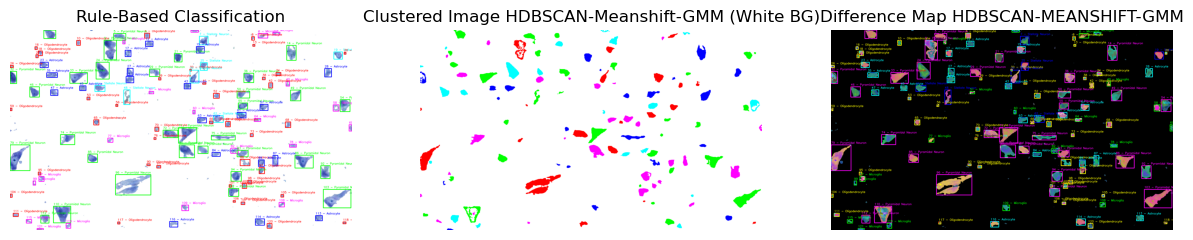

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
rule_based_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\final_classified_nissl_cells.png" # Update with actual path
clustered_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\clustered_nissl_image_hdbscan-meanshift-gmm.png"# Update with actual path

rule_based = cv2.imread(rule_based_path)
clustered = cv2.imread(clustered_path)

# Ensure images are loaded
if rule_based is None or clustered is None:
    raise ValueError("One or both images could not be loaded. Check file paths.")

# Resize images to match dimensions
if rule_based.shape[:2] != clustered.shape[:2]:
    clustered = cv2.resize(clustered, (rule_based.shape[1], rule_based.shape[0]))

# Convert black background to white in the clustered image (invert colors)
gray_clustered = cv2.cvtColor(clustered, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_clustered, 10, 255, cv2.THRESH_BINARY)  # Detect foreground
white_bg = np.full_like(clustered, 255)  # Create a white background
clustered_white_bg = np.where(mask[:, :, None] > 0, clustered, white_bg)  # Apply mask

# Compute absolute color difference
diff = cv2.absdiff(rule_based, clustered_white_bg)

# Display images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(rule_based, cv2.COLOR_BGR2RGB))
plt.title("Rule-Based Classification")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(clustered_white_bg, cv2.COLOR_BGR2RGB))
plt.title("Clustered Image HDBSCAN-Meanshift-GMM (White BG)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff, cmap="hot")
plt.title("Difference Map HDBSCAN-MEANSHIFT-GMM")
plt.axis("off")

plt.show()
